# Word Embeddings

# Representing Text as Numbers
Machine learning models take vectors as input. When dealing with text data, the first thing to decide is a strategy for converting strings (text) to numbers before feeding it into the model. There are generally three strategies of this process of <i>word vectorization</i>:
1. One-hot encoding
2. Encode each word with a unique number
3. Word embeddings

## One-Hot Encoding

Consider the sentence "she sat on my face." The vocabulary (or unique words) is `["she", "sat", "face", "on", "my"]`. To represent each word, we create a zero vector with length equal to the length of the vocabulary (in this case, `length = 5`). It might look something like this:

This approach is mad inefficient.

## Word Embeddings

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tds

import matplotlib.pyplot as plt

import io

In [3]:
!pip install tensorflow-datasets

     |████████████████████████████████| 2.4MB 1.8MB/s eta 0:00:01
     |████████████████████████████████| 829kB 5.2MB/s eta 0:00:01
Failed to build future promise googleapis-common-protos
    Running setup.py install for future ... done
    Running setup.py install for googleapis-common-protos ... done
    Running setup.py install for promise ... done


In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Using the Embedding Layer
The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their *embeddings*). The dimensionality, or width, of the embedding is a parameter that you can experiment with to see what works well for the problem at hand.

In [8]:
embedding_layer = Embedding(1000, 5)

Upon initializing the Embedding layer, the weights are randomly initialized (just like any other layer). During training, the weights are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words. 

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table. 

In [9]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.01895238,  0.04811767, -0.04818218,  0.04420339,  0.0255296 ],
       [ 0.03690957,  0.0031768 , -0.00181247,  0.03330058,  0.0284372 ],
       [-0.03085363, -0.03966909, -0.04177362, -0.04182965, -0.04382652]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). 

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`. 

In [10]:
result = embedding_layer(tf.constant([[0,1,2], [3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch fo sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense (fully-connected) layer. We will use pooling in this tutorial because it's the simplest. 

# Learning Embeddings from Scratch
We will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. 

In [11]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info = True, as_supervised = True
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/jovyan/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. The "_" represent spaces.

In [12]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews. 

In [21]:
padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

Note the trailing zeros because the batch is padded to the longest example. 

In [14]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[6508,   27,   13, ...,    0,    0,    0],
       [  12,  838, 7968, ...,    0,    0,    0],
       [ 644,   21,  481, ...,    0,    0,    0],
       ...,
       [  19,   77,  233, ...,    0,    0,    0],
       [  12,   31,  165, ...,    0,    0,    0],
       [ 977,    1, 2222, ...,    0,    0,    0]])

## Build a Simple Model
We will use the Keras Sequential API to define our model. In this case, it is a "Continuous Bag of Words" style model, meaning:
- The next Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are `(batch, sequence, embedding)`. 
- A `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This enables the model to handle input of variable length in the simplest way possible. 
- The fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units. 
- The last layer is densely connected with a single output node. Using the activation function, the value is a float between 0 and 1, representing a probability that the review is positive.

In [17]:
embedding_dim = 16

model = Sequential([
    Embedding(encoder.vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


## Compile and Train the Model

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_batches,
    epochs = 10,
    validation_data = test_batches, validation_steps = 20)

Epoch 1/10
2500/2500 [==============================] - 24s 10ms/step - loss: 0.4945 - accuracy: 0.7668 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2759 - accuracy: 0.8974 - val_loss: 0.3174 - val_accuracy: 0.8300
Epoch 3/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2229 - accuracy: 0.9198 - val_loss: 0.2980 - val_accuracy: 0.8800
Epoch 4/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1909 - accuracy: 0.9310 - val_loss: 0.2250 - val_accuracy: 0.9050
Epoch 5/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1703 - accuracy: 0.9398 - val_loss: 0.2304 - val_accuracy: 0.9000
Epoch 6/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1521 - accuracy: 0.9474 - val_loss: 0.3414 - val_accuracy: 0.8750
Epoch 7/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1388 - accuracy: 0.9542 - val_loss: 0.4226

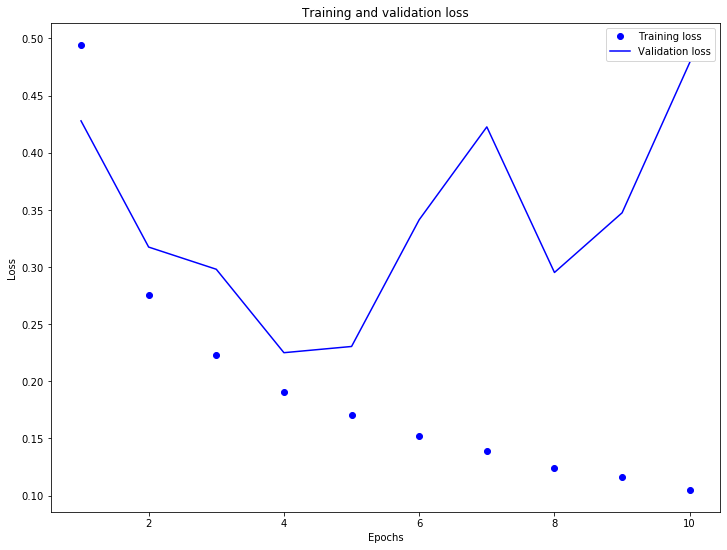

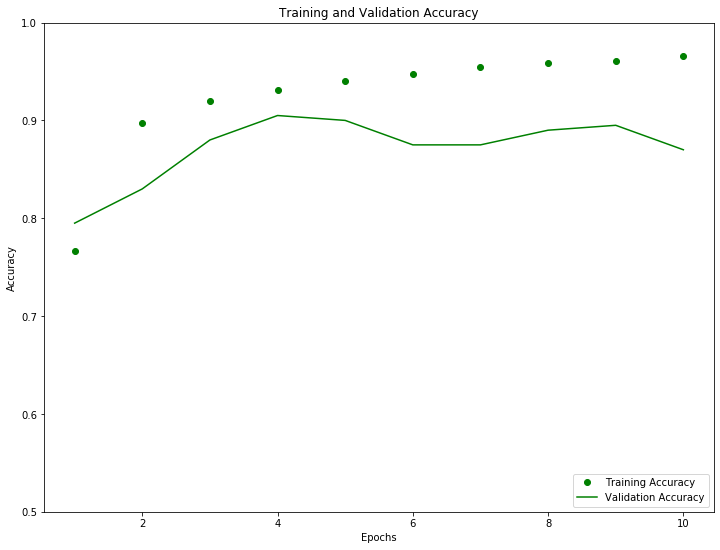

In [26]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(epochs, acc, 'go', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5, 1))
plt.show()

## Retrieve the Learned Embeddings
The word embeddings will be a matrix of shape `(vocab_size, embedding-dimension)`. 

In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words). 

In [30]:
encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]  # skip 0, it's padding
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
    
out_v.close()
out_m.close()